## Create urban built-up and population density gradients for multiple cities

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely import wkt
import os
import gdal
from rasterio.mask import mask
import rasterio
import pylab as pl
from rasterio.warp import calculate_default_transform, reproject, Resampling
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#dat = pd.read_csv("..\\GHSL_NewVersion\\GHSL_UCDB_new.csv")

In [3]:
cities = ['Accra', 'Buenos Aires', 'Paris', 'Chicago', 'Dhaka', 'Shanghai']

In [2]:
def return_point(city):
    #dat = pd.read_csv("..\\GHSL_NewVersion\\GHSL_UCDB_new.csv")
    #df = dat[dat.UC_NM_MN == city]
    
    #point = Point(df.GCPNT_LON.iloc[0], df.GCPNT_LAT.iloc[0])
    
    import osmnx as ox
    
    point = ox.gdf_from_place('Dhaka, Bangladesh')['geometry'].iloc[0]
    
    return point

In [3]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio accepts them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [4]:
def get_buffer_vars(city):
    
    point = return_point(city)
    buff_500 = point.buffer(0.01, 128)
    buff_1000 = point.buffer(0.015, 128)
    dough_1000 = buff_1000.difference(buff_500)
    buff_1500 = point.buffer(0.02, 128)
    dough_1500 = buff_1500.difference(buff_1000)
    buff_2000 = point.buffer(0.025, 128)
    dough_2000 = buff_2000.difference(buff_1500)
    
    return buff_500, buff_1000, buff_1500, buff_2000

In [5]:
def convert_geom_to_shp(shapely_polygon, city, out_name_postfix):
    df = pd.DataFrame(
    {'City': [city],
     'geometry': [wkt.dumps(shapely_polygon)]})
    
    df['geometry'] = df['geometry'].apply(wkt.loads)
    
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    gdf.to_file(os.getcwd()+'\\shapefiles\\{a}_{b}.shp'.format(a=city, b=out_name_postfix))
    
    return os.getcwd()+'\\shapefiles\\{a}_{b}.shp'.format(a=city, b=out_name_postfix)

In [6]:
def reproject_raster(source_path, destination_path):

    dst_crs = 'EPSG:4326'
    
    #try:
    with rasterio.open(source_path, CHECK_DISK_FREE_SPACE =False) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

    with rasterio.open(destination_path, 'w',**kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
    #except rasterio._err.CPLE_FileIOError:
    #    print('File too big! Cant open')
    #except rasterio._base.RasterioIOError:
    #    print('Raster file empty!')
        

In [7]:
def get_clipped_density(shpfile_path, raster_path):
    """
    Function to clip the population gridded data by polygons from datasets.
    """
    shp = gpd.read_file(shpfile_path)
    shp.crs = {'init':'epsg:4326'}
    shp = shp.to_crs(epsg=4326)
    
    coords = getFeatures(shp)
    
    new = rasterio.open(raster_path)
    
    try:
        out_img, out_transform = mask(dataset=new, shapes=coords, crop=True)
        new_out = out_img[out_img > 0]
        return new_out.sum()/len(new_out)
        
    except ValueError:
        print('No Overlap between raster and polygon.')
        return

In [8]:
def main(city):
    
    point = return_point(city)
    
    path = r"C:\\Users\\wb542830\\OneDrive - WBG\\GPSUR\Data\\GHSL_builtup_250m"
    
    temp = os.listdir(path)
    
    buff_500, buff_1000, buff_1500, buff_2000 = get_buffer_vars(city)
    
    dic = {'500m':buff_500, '1000m':buff_1000, '1500m':buff_1500, '2000m':buff_2000}
    
    shp_lis = []
    for res in dic.keys():  
        shp_lis.append(convert_geom_to_shp(dic[res], city, res))
    
    sum_dic = {}
    
    for i in [1990, 2000, 2014]:
        for j in temp:
            if str(i) in j.split('_'):
                path_ext = path+"\\"+j
                
                TIF_lis = [i for i in os.listdir(path_ext) if i.endswith('.TIF')]
        
                for k in TIF_lis:
                    reproject_raster(path_ext+"\\"+k, path_ext+"\\GHS_builtup_"+str(i)+"_reprojected_4326"+k.split('_')[-1].split('.')[0]+'.tif')
            
                tif_lis = [i for i in os.listdir(path_ext) if i.endswith('.tif')]
        
                sum_lis = []

                for shp in shp_lis:
                    for ras in tif_lis:
                        sum_lis.append(get_clipped_density(shp, path_ext+"\\"+ras))
                sum_dic[i] = sum_lis
                
    return sum_dic

In [9]:
di = main('Dhaka')

C:\Users\wb542830\AppData\Roaming\Python\Python36\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\wb542830\AppData\Roaming\Python\Python36\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


RasterioIOError: Dataset is closed: C:\\Users\\wb542830\\OneDrive - WBG\\GPSUR\Data\\GHSL_builtup_250m\GHSL_1990_split\GHS_BUILT_LDS1990_GLOBE_R2018A_54009_250_V2_010.TIF

In [161]:
di

{1975: [None,
  56.34523362379808,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  56.01008977809874,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  52.235044380868544,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  51.50370065789474,
  None,
  None,
  None,
  None,
  None,
  None],
 1990: [],
 2000: [],
 2014: []}

In [146]:
lis_1975 = [np.round(i,2) for i in di[1975] if i]

In [147]:
lis_1975

[56.35, 56.01, 52.24, 51.5]

In [132]:
x = [500, 1000, 1500, 2000]

(0, 100)

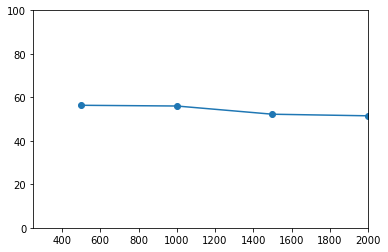

In [124]:
pl.plot(x, lis_1975, '-o')
pl.xlim(250,2000)
pl.ylim(0,100)

In [121]:
import plotly.express as px

In [128]:
fig = px.line(x = x, y = lis_1975, labels = {'x' : 'buffer distance (in m)', 'y' : 'share of built-up'}, 
              range_x = [250,2000], range_y = [0,100])
fig.show()

In [157]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Scatter(x=x, y=lis_1975, mode='lines+markers', text=lis_1975,  name='% Built-up'))

fig.update_layout(
    title={
        'text': "Share of built-up in 1975 at different buffer levels",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.update_layout(xaxis_title='Buffer Distance (in m)',
                   yaxis_title='% Share of Built-up')
fig.update_traces(hoverinfo='text+name', mode='lines+markers')
fig.update_xaxes(range=[250,2100])
fig.update_yaxes(range=[0,100])

fig.show()

In [17]:
path = r"C:\\Users\\wb542830\\OneDrive - WBG\\GPSUR\Data\\GHSL_builtup_250m"
temp = os.listdir(path)
for i in [1990, 2000, 2014]:
    for j in temp:
        if str(i) in j.split('_'):
            path_ext = path+"\\"+j

            TIF_lis = [i for i in os.listdir(path_ext) if i.endswith('.TIF')]
            for k in TIF_lis[:2]:
                print(path_ext+"\\"+k)
                print(path_ext+"\\GHS_builtup_"+str(i)+"_reprojected_4326"+k.split('_')[-1].split('.')[0]+'.tif')
                reproject_raster(path_ext+"\\"+k, path_ext+"\\GHS_builtup_"+str(i)+"_reprojected_4326"+k.split('_')[-1].split('.')[0]+'.tif')
            
            tif_lis = [i for i in os.listdir(path_ext) if i.endswith('.tif')]

C:\\Users\\wb542830\\OneDrive - WBG\\GPSUR\Data\\GHSL_builtup_250m\GHSL_1990_split\GHS_BUILT_LDS1990_GLOBE_R2018A_54009_250_V2_010.TIF
C:\\Users\\wb542830\\OneDrive - WBG\\GPSUR\Data\\GHSL_builtup_250m\GHSL_1990_split\GHS_builtup_1990_reprojected_4326010.tif


RasterioIOError: Dataset is closed: C:\\Users\\wb542830\\OneDrive - WBG\\GPSUR\Data\\GHSL_builtup_250m\GHSL_1990_split\GHS_BUILT_LDS1990_GLOBE_R2018A_54009_250_V2_010.TIF

In [16]:
TIF_lis[1]

'GHS_BUILT_LDS2014_GLOBE_R2018A_54009_250_V2_01.TIF'

In [23]:
l= rasterio.open("C:\Users\wb542830\OneDrive - WBG\GPSUR\Data\GHSL_builtup_250m\GHSL_1990_split\GHS_BUILT_LDS1990_GLOBE_R2018A_54009_250_V2_00.TIF")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-23-fd56775244d5>, line 1)

In [27]:
os.getcwd()

'C:\\Users\\wb542830\\OneDrive - WBG\\GPSUR\\Data\\Analysis'

In [20]:
dst_crs = 'EPSG:4326'
    
    #try:
with rasterio.open("C:\\Users\\wb542830\\OneDrive - WBG\\GPSUR\Data\\GHSL_builtup_250m\GHSL_1990_split\GHS_BUILT_LDS1990_GLOBE_R2018A_54009_250_V2_011.TIF", CHECK_DISK_FREE_SPACE =False) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

with rasterio.open("C:\\Users\\wb542830\\OneDrive - WBG\\GPSUR\Data\\GHSL_builtup_250m\GHSL_1990_split\GHS_builtup_1990_reprojected_4326011.tif", 'w',**kwargs) as dst:
    for i in range(1, src.count + 1):
        reproject(
            source=rasterio.band(src, i),
            destination=rasterio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)

CPLE_FileIOError: Free disk space available is 815104 bytes, whereas 1163610960 are at least necessary. You can disable this check by defining the CHECK_DISK_FREE_SPACE configuration option to FALSE.

In [21]:
with rasterio.open("C:\\Users\\wb542830\\OneDrive - WBG\\GPSUR\Data\\GHSL_builtup_250m\GHSL_1990_split\GHS_BUILT_LDS1990_GLOBE_R2018A_54009_250_V2_011.TIF", CHECK_DISK_FREE_SPACE =False) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

In [22]:
with rasterio.open("C:\\Users\\wb542830\\OneDrive - WBG\\GPSUR\Data\\GHSL_builtup_250m\GHSL_1990_split\GHS_builtup_1990_reprojected_4326011.tif", 'w',**kwargs) as dst:
    for i in range(1, src.count + 1):
        reproject(
            source=rasterio.band(src, i),
            destination=rasterio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)

CPLE_FileIOError: Free disk space available is 0 bytes, whereas 1163610960 are at least necessary. You can disable this check by defining the CHECK_DISK_FREE_SPACE configuration option to FALSE.